###### Imports

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta

## Set variables for time limit

In [2]:
#create datetime objects for today and 12 30 day months before today
today = datetime.now()
pastlimit = today - timedelta(days=12*30)
pastlimit

datetime.datetime(2022, 2, 16, 12, 1, 46, 365853)

In [3]:
#the API takes the floating datetime as a string in a certain format, convert to that
today_str = today.strftime("%Y-%m-%dT%H:%M:%S")
pastlimit_str = pastlimit.strftime("%Y-%m-%dT%H:%M:%S")

## Make API call

In [4]:
endpoint = 'https://data.sfgov.org/resource/RowID.json'
params = {'$select': 'received_dttm, on_scene_dttm, battalion', #select the three columns needed for analysis
         '$where': "received_dttm between '{past}' and '{present}'".format(past = pastlimit_str, present = today_str), #use vars to set time frame
         '$limit': 1000000} #make sure we're not loosing anything by setting a high limit
response = requests.get(endpoint, params = params)
response.status_code

200

## Create DataFrame, check data

In [5]:
#concert response to pandas dataframe
df = pd.DataFrame(data = response.json())
print(df.shape)
df.head()

(322714, 3)


,received_dttm,battalion,on_scene_dttm
0,2022-02-16T12:01:50.000,B02,NaN
1,2022-02-16T12:01:50.000,B02,2022-02-16T12:10:02.000
2,2022-02-16T12:01:56.000,B02,NaN
3,2022-02-16T12:01:56.000,B02,2022-02-16T12:07:26.000
4,2022-02-16T12:06:41.000,B02,2022-02-16T12:14:40.000


In [6]:
df.tail()

,received_dttm,battalion,on_scene_dttm
322709,2023-02-11T02:36:34.000,B05,2023-02-11T02:42:26.000
322710,2023-02-11T02:49:35.000,B03,NaN
322711,2023-02-11T02:50:44.000,B02,2023-02-11T02:55:56.000
322712,2023-02-11T02:50:44.000,B02,2023-02-11T02:54:30.000
322713,2023-02-11T02:56:27.000,B02,NaN


In [7]:
#check for null values: it slowed down the API call to filter them out, so checking here and dropping any in the time columns
df['received_dttm'].isna().sum()

0

In [8]:
df['on_scene_dttm'].isna().sum()

66116

In [9]:
#check for null values in battalions too
df['battalion'].isna().sum()

0

In [10]:
df.dropna(inplace = True)

In [11]:
#make sure datatypes are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256598 entries, 1 to 322712
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   received_dttm  256598 non-null  object
 1   battalion      256598 non-null  object
 2   on_scene_dttm  256598 non-null  object
dtypes: object(3)
memory usage: 7.8+ MB


In [12]:
#the datetimes were imported as objects so convert these to datetime
cols = ['received_dttm', 'on_scene_dttm']
df[cols] = df[cols].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256598 entries, 1 to 322712
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   received_dttm  256598 non-null  datetime64[ns]
 1   battalion      256598 non-null  object        
 2   on_scene_dttm  256598 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 7.8+ MB


In [13]:
#check range
date_range_received_calls = str(df['received_dttm'].dt.date.min()) + ' to ' +str(df['received_dttm'].dt.date.max())
date_range_received_calls

'2022-02-16 to 2023-02-11'

In [14]:
#check range
date_range_on_scene = str(df['on_scene_dttm'].dt.date.min()) + ' to ' +str(df['on_scene_dttm'].dt.date.max())
date_range_on_scene

'2022-02-16 to 2023-02-11'

## Create the columns needed to evaluate percentile response times

In [15]:
df['Response Time'] = df['on_scene_dttm'] - df['received_dttm']
df.head()

,received_dttm,battalion,on_scene_dttm,Response Time
1,2022-02-16 12:01:50,B02,2022-02-16 12:10:02,0 days 00:08:12
3,2022-02-16 12:01:56,B02,2022-02-16 12:07:26,0 days 00:05:30
4,2022-02-16 12:06:41,B02,2022-02-16 12:14:40,0 days 00:07:59
5,2022-02-16 12:06:41,B02,2022-02-16 12:14:05,0 days 00:07:24
7,2022-02-16 12:08:33,B08,2022-02-16 12:16:33,0 days 00:08:00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256598 entries, 1 to 322712
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   received_dttm  256598 non-null  datetime64[ns] 
 1   battalion      256598 non-null  object         
 2   on_scene_dttm  256598 non-null  datetime64[ns] 
 3   Response Time  256598 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(1), timedelta64[ns](1)
memory usage: 9.8+ MB


In [17]:
#convert timedelta to a string datatype to split it up into hours/mins/seconds
df['Response Time'] = df['Response Time'].astype(str).str.slice(start = -8)

In [18]:
times = df['Response Time'].str.split(pat = ':', expand = True)
df['Response Hours'] = times[0]
df['Response Minutes'] = times[1]
df['Response Seconds'] = times[2]

In [19]:
cols = ['Response Hours', 'Response Minutes', 'Response Seconds']
df[cols] = df[cols].astype(int)

In [20]:
#find seconds in all time units to add and overwrite (will drop columns, don't need more)
df['Response Hours'] = df['Response Hours'] * 36000
df['Response Minutes'] = df['Response Minutes'] * 60

In [21]:
df['Response Time Seconds'] = df['Response Hours'] + df['Response Minutes'] + df['Response Seconds']

In [22]:
df.drop(columns = ['received_dttm', 'on_scene_dttm', 'Response Time', 'Response Hours', 'Response Minutes', 'Response Seconds'], inplace = True)

## Group by battalion and quantile, create any relevant columns and adjust datatypes

In [23]:
df = df.groupby('battalion').quantile(.90).reset_index(drop = False)

In [24]:
df['90th Percentile Response Time: Minutes'] = df['Response Time Seconds']/60
df['90th Percentile Response Time: Time Delta'] = pd.to_timedelta(df['Response Time Seconds'], unit = 'sec')

In [25]:
#nicer
df.rename(columns = {'battalion': 'Battalion', 'Response Time Seconds': '90th Percentile Response Time: Seconds'}, inplace = True)

In [26]:
df.head()

,Battalion,90th Percentile Response Time: Seconds,90th Percentile Response Time: Minutes,90th Percentile Response Time: Time Delta
0,B01,1356.0,22.600000,0 days 00:22:36
1,B02,1227.0,20.450000,0 days 00:20:27
2,B03,1328.0,22.133333,0 days 00:22:08
3,B04,1296.3,21.605000,0 days 00:21:36.300000
4,B05,1282.0,21.366667,0 days 00:21:22


## Export .csv

In [27]:
df.to_csv('JoannaMcCall_battalions_90thpercentiles.csv', index = False)

## Visualize

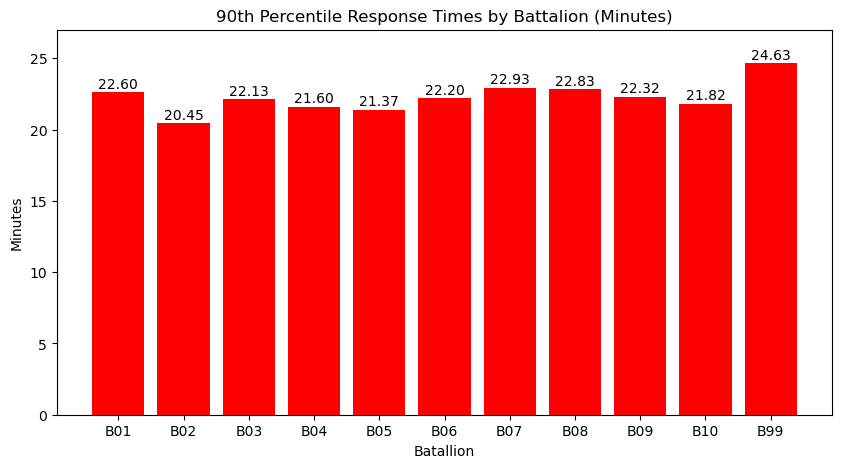

In [28]:
x = df['Battalion']
y = df['90th Percentile Response Time: Minutes']
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(x, y, color = 'red')
ax.set(title = '90th Percentile Response Times by Battalion (Minutes)', xlabel = 'Batallion', ylabel = 'Minutes')
for j, k in zip(x, y):
        label = '{:,.2f}'.format(k)
        plt.annotate(label, (j, k), textcoords = 'offset points', xytext = (0, 3), ha = 'center')
ax.set_ylim(top = 27)
plt.show()
plt.close();